# Exercice API SNCF corrigé 

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Partie 0 - modules recommandés et connexion à l'API 

Il vous faudra sûrement les modules suivant : 

- requests
- datetime
- pandas
- matplotlib

Créer un login pour vous connecter à l'API de la SNCF https://data.sncf.com/api 

Vous pouvez maintenant commencer. Ce notebook peut prendre du temps à s'éxécuter, surout à partir de la partie 3

In [ ]:
# !!!!! Attention à bien mettre votre token ici  !!!!!

token_auth = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

In [ ]:
import keyring, os
if "XXXXXX" in token_auth:
    token_auth = keyring.get_password("sncf", os.environ["COMPUTERNAME"] + "key")

## Partie 1 - Trouver les gares accessibles _via_ la SNCF

- Trouver l'ensemble des gares disponibles sur l'API et créer un fichier csv avec les codes de la gare, son nom et ses coordonnées latitude et longitude, ainsi que les informations administratives de la région quand elles sont disponibles

- Représentez les sur un graphique

In [ ]:
import pandas as pd
import requests

In [ ]:
df = pd.DataFrame() 

def page_gares(numero_page) :
    return requests.get('https://api.sncf.com/v1/coverage/sncf/stop_areas?start_page={}'.format(numero_page), 
                        auth=(token_auth, ''))

######################################
# on commence par la première page qui nous donne le nombre de résultats par page ainsi que le nombre total de résultats                    

page_initiale = page_gares(0)                        
item_per_page = page_initiale.json()['pagination']['items_per_page']
total_items = page_initiale.json()['pagination']['total_result']

# on fait une boucle sur toutes les pages suivantes 

for page in range(int(total_items/item_per_page)+1) :   
    #print("je suis à la page",page)
    stations_page = page_gares(page)
    
    ensemble_stations = stations_page.json()
    
    # on ne retient que les informations qui nous intéressent 
    
    for station in ensemble_stations['stop_areas'] :

        station['lat'] = station['coord']['lat']
        station["lon"]  = station['coord']['lon']

        if 'administrative_regions' in station.keys() : 
            for var_api, var_df in zip(['insee','name','label','id','zip_code'],
                                       ['insee','region','label_region','id_region','zip_code']) : 
                station[var_df] = station['administrative_regions'][0][var_api]

        [station.pop(k,None) for k in ['coord','links','administrative_regions']]

        df = df.append(pd.DataFrame.from_dict(station,orient='index').T, ignore_index=True)

df.to_csv("./ensemble_gares.csv")        

In [ ]:
df = pd.read_csv("./ensemble_gares.csv", encoding = "ISO-8859-1")
print(df.columns, df.shape)
# Exemple des informations sur une gare
df.ix[317]

Index(['Unnamed: 0', 'codes', 'id', 'id_region', 'insee', 'label',
       'label_region', 'lat', 'lon', 'name', 'region', 'timezone', 'zip_code'],
      dtype='object') (3029, 13)


Unnamed: 0                                                    317
codes           [{'type': 'CR-CI-CH', 'value': '0087-182063-BV'}]
id                                      stop_area:OCE:SA:87182063
id_region                                       admin:38246extern
insee                                                       68224
label                                         Mulhouse (Mulhouse)
label_region                               Mulhouse (68100-68200)
lat                                                       47.7418
lon                                                       7.34283
name                                                     Mulhouse
region                                                   Mulhouse
timezone                                             Europe/Paris
zip_code                                              68100;68200
Name: 317, dtype: object

In [ ]:
# on crée un dictionnaire des correspondances entre les noms et les codes des gares
dict_label_gare_code = df[['label','id']].set_index('label').to_dict()['id']
dict_nom_gare_code = df[['name','id']].set_index('name').to_dict()['id']

Index(['Unnamed: 0', 'codes', 'id', 'id_region', 'insee', 'label',
       'label_region', 'lat', 'lon', 'name', 'region', 'timezone', 'zip_code'],
      dtype='object')


c:\python35_x64\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
c:\python35_x64\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


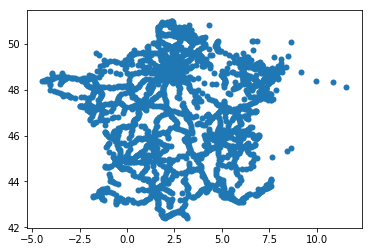

In [ ]:
print(df.columns)

# graphique dans le plan des gares
%matplotlib inline
import matplotlib.pyplot as plt
lng_var = df[df['lat']>35][df['lat']<60]["lon"].tolist()
lat_var = df[df['lat']>35][df['lat']<60]["lat"].tolist()
plt.scatter(x = lng_var , y = lat_var,marker = "o")
plt.show()

## Les trajets depuis la Gare de Lyon

### Partons à Lyon : le 17 novembre 2016 à 19h57

Imaginez que vous vouliez un peu voyager hors de Paris, et il se trouve que justement on vous propose de passer quelques jours à Lyon. Vous partez le 17 novembre vers 19h50 pour ne pas trop écourter votre journée de travail. 

#### Question 1

- Commencez par récupérer les informations sur le trajet entre Paris Gare de Lyon et Lyon Perrache le 17 novembre à 19h57

    - Paris - Gare de Lyon (code de la gare : __stop\_area:OCE:SA:87686006__)

    - Lyon - Gare Lyon Perrache (code de la gare : __stop\_area:OCE:SA:87722025__)
    
    - Indice : utiliser la requête "journeys"
    
    - Autre indice : le format de la date est AAAAMMJJTHHMMSS (Année, mois, jour, heure, minutes, secondes)
    
- Répondez aux questions suivantes 
    - combien y a-t-il d'arrêts entre ces deux gares ? (utilisez la clé 'journeys')
    - combien de temps d'arrêt à chacune d'elles ?

In [ ]:
##### une fonction qui sera utile pour calculer des temps

from datetime import datetime

def convertir_en_temps(chaine) : 
    ''' on convertit en date la chaine de caractères de l API'''
    return datetime.strptime(chaine.replace('T',''),'%Y%m%d%H%M%S')

In [ ]:
# informations sur le trajet

date_depart = "20161117T195700"
gare_depart = 'stop_area:OCE:SA:87686006'
gare_arrivee = 'stop_area:OCE:SA:87722025'

# ensemble des départs 

paris_lyon = requests.get('https://api.sncf.com/v1/coverage/sncf/journeys?'\
                          'from={}&to={}&datetime={}'.format(gare_depart, gare_arrivee, date_depart), \
                         auth=(token_auth, '')).json()

In [ ]:
# les gares du chemin entre Paris et Lyon sur ce trajet
# ainsi que le temps d'arrêt
for i in paris_lyon['journeys'][0]['sections'][1]['stop_date_times'] : 
    print(i['stop_point']['name'], 
          convertir_en_temps(i['departure_date_time'])-convertir_en_temps(i['arrival_date_time']),"minutes d'arrêt")

Paris-Gare-de-Lyon 0:00:00 minutes d'arrêt
Creusot - TGV (le) 0:02:00 minutes d'arrêt
Mâcon-Loché-TGV 0:03:00 minutes d'arrêt
Lyon-Part-Dieu 0:08:00 minutes d'arrêt
Lyon-Perrache 0:00:00 minutes d'arrêt


#### Question 2
Vous êtes un peu pressé et vous avez peur de vous tromper en arrivant à la gare car d'autres TGV partent à peu près en même temps (à partir de 19h00) de la gare de Lyon. 

- Si vous demandez à l'API, combien de résultats vous donne-t-elle ?

In [ ]:
### les trains qui partent autour de 19h00
departs_paris = requests.get('https://api.sncf.com/v1/coverage/sncf/stop_points/stop_point:OCE:SP:'\
                             'TGV-87686006/departures?from_datetime={}'.format(date_depart) ,
                        auth=(token_auth, '')).json()

# Nombre de trains que l'API renvoit à partir de cet horaire-là
print(len(departs_paris['departures']))

10


- Quels sont les horaires de départ de ces trains ? 

In [ ]:
for i in range(len(departs_paris['departures'])) :
    print(departs_paris['departures'][i]['stop_date_time']['departure_date_time'])

20161117T195700
20161117T201500
20161117T201900
20161117T202300
20161117T204100
20161118T054700
20161118T060500
20161118T060500
20161118T062800
20161118T062800


- Parmi ces trains, combien de trains ont pour destination finale Lyon et qui partent le 17 novembre ?

In [ ]:
nombre_trains_pour_lyon = 0

for depart in departs_paris['departures'] :     
    if "Lyon" in depart['display_informations']['direction'] : 
        if convertir_en_temps(depart['stop_date_time']['arrival_date_time']) > convertir_en_temps(date_depart) and \
        convertir_en_temps(depart['stop_date_time']['arrival_date_time']) < datetime(2016,11,18,0,0,0):
            nombre_trains_pour_lyon += 1
            print("le prochain départ pour Lyon sera le", convertir_en_temps(depart['stop_date_time']['arrival_date_time']))
        
print("Il y a" , nombre_trains_pour_lyon, "train(s) pour Lyon dans les trains proposés", 
      "par l'API qui partent encore le 17 novembre")

le prochain départ pour Lyon sera le 2016-11-17 20:41:00
Il y a 1 train(s) pour Lyon dans les trains proposés par l'API qui partent encore le 17 novembre


-------------------------

### C'est quand qu'on va où ?
- En fait, vous n'êtes plus très sûr de vouloir aller à Lyon. Mais bon maintenant vous êtes Gare de Lyon et il est 18h00. 

#### Question 3
- Combien de tgv partent entre 18h00 et 20h00 ?
- Lequel arrive le plus tôt à sa destination finale ?

In [ ]:
# on crée deux fonctions : 

def trouver_destination_tgv(origine, datetime) : 
    '''Permet d avoir les 10 prochains départs d une gare donnée '''
    return requests.get('https://api.sncf.com/v1/coverage/sncf/stop_points/{}/' \
                        'departures?from_datetime={}'.format(origine, datetime) ,
                        auth=(token_auth, '')).json()

def trouver_trajet_dispo_max_heure(gare_depart, date_heure_depart, date_heure_max) : 
    ''' Permet d avoir toutes les informations sur des trajets partant d une gare entre une date X et une date Y '''
    
    destinations = []
    
# on interroge l'API tant qu'il renvoie des informations sur les trains partant de Gare de lyon 

    while convertir_en_temps(date_heure_depart) <  convertir_en_temps(date_heure_max) :
    # on prend toutes les destinations qui partent à partir d'une certaine heure
        destinations = destinations + trouver_destination_tgv(gare_depart, date_heure_depart)['departures']
        
        nombre_resultats = trouver_destination_tgv(gare_depart, date_heure_depart)['pagination']['items_on_page']
        
        # on trouve l'heure max de la première série de 10 solutions que l'application renvoie
        # on remplace l'heure qu'on cherche par celle là
        date_heure_depart = trouver_destination_tgv(gare_depart,
                                     date_heure_depart)['departures'][nombre_resultats-1]['stop_date_time']['departure_date_time']

    return destinations

In [ ]:
# on trouve l'ensemble des trajets dont le départ est compris entre 18h00 et 20h00

date_heure = '20161117T180000'
max_date_heure = '20161117T200000'
gare_initiale = 'stop_point:OCE:SP:TGV-87686006'

# on demande à avoir tous les trajets partant de gare de lyon entre 18h et 20h

destinations_depuis_paris_max_20h = trouver_trajet_dispo_max_heure(gare_initiale, date_heure, max_date_heure)

# on veut supprimer ceux pour lesquels le départ est après 20h00

dictionnaire_destinations = {}

i = 0

for depart in destinations_depuis_paris_max_20h :    
    print(depart['display_informations']['direction'],depart['stop_date_time']['departure_date_time'])
    if convertir_en_temps(depart['stop_date_time']['departure_date_time']) < convertir_en_temps(max_date_heure) : 
        i += 1
        dictionnaire_destinations[i] = depart 
    
print("Je peux prendre", len(dictionnaire_destinations.keys()), 
      "trains qui partent entre 18h et 20h de Gare de Lyon le 17 novembre 2016")

Perpignan (Perpignan) 20161117T180700
Toulon (Toulon) 20161117T181900
Marseille-St-Charles (Marseille) 20161117T183700
Lyon-Perrache (Lyon) 20161117T184100
Annecy (Annecy) 20161117T184500
Grenoble (Grenoble) 20161117T184900
Besançon-Viotte (Besançon) 20161117T185300
St-Etienne-Châteaucreux (Saint-Étienne) 20161117T185700
Béziers (Béziers) 20161117T191300
Mulhouse (Mulhouse) 20161117T192300
Mulhouse (Mulhouse) 20161117T192300
Lyon-Perrache (Lyon) 20161117T192900
Toulon (Toulon) 20161117T193700
Avignon-Centre (Avignon) 20161117T194100
Grenoble (Grenoble) 20161117T194100
Lyon-Perrache (Lyon) 20161117T195700
Montpellier-Saint-Roch (Montpellier) 20161117T201500
Marseille-St-Charles (Marseille) 20161117T201900
Mulhouse (Mulhouse) 20161117T202300
Lyon-Part-Dieu (Lyon) 20161117T204100
Je peux prendre 16 trains qui partent entre 18h et 20h de Gare de Lyon le 17 novembre 2016


In [ ]:
# on cherche celui qui arrive le plus tôt à sa destination

def trouver_info_trajet(dep, arr, heure) :
     return requests.get('https://api.sncf.com/v1/coverage/sncf/journeys?from={}&to={}&datetime={}'.format(dep,arr,heure), \
                         auth=(token_auth, '')).json()['journeys'][0]

# on initiale l'heure à la fn de la journée : on veut réduire cette variable au maximum

heure_minimale = datetime(2016,11,17,23,59,59)

# parmi toutes les destinations possibles, on recherche le train qui arrive le plus tôt à sa destination finale
for code, valeurs in dictionnaire_destinations.items() : 
    ''' on prend le code de la gare'''
    code_destination = dictionnaire_destinations[code]['route']['direction']['id']
    ''' on regarde à quelle heure arrive le train'''
    trajet = trouver_info_trajet('stop_area:OCE:SA:87686006',code_destination,
                                   dictionnaire_destinations[code]['stop_date_time']['arrival_date_time'])    
    if heure_minimale >  convertir_en_temps(trajet['arrival_date_time']) : 
        heure_minimale = convertir_en_temps(trajet['arrival_date_time'])
        destination_la_plus_rapide = dictionnaire_destinations[code]

In [ ]:
print(destination_la_plus_rapide['display_informations']['direction'], heure_minimale)

Lyon-Perrache (Lyon) 2016-11-17 20:57:00


### Et les correspondances ? 

#### Question 4

- On va essayer de voir jusqu'où on peut aller, en prenant des trains au départ de la Gare de Lyon : 
    - Quelles sont toutes les gares atteignables en partant le 17 novembre, sans faire de changement et sans partir après minuit ?
    - Si on prend un de ces trains, jusqu'où peut-on aller, avec une correspondance, sans partir après 8h le lendemain matin ?

In [ ]:
# on va trouver toutes les gares qui sont sur les trajets des trains retenus donc atteignables sans correspondance

def trouver_toutes_les_gares_du_trajet(gare_depart, gare_arrivee_finale, horaire_depart) :
    return requests.get('https://api.sncf.com/v1/coverage/sncf/journeys?from={}&to={}' \
                          '&datetime={}'.format(gare_depart,gare_arrivee_finale,horaire_depart), \
                         auth=(token_auth, '')).json()

In [ ]:
# Exemple pour la première gare de la liste 
gare_depart = dictionnaire_destinations[1]['stop_point']['id']
gare_arrivee = dictionnaire_destinations[1]['route']['direction']['id']
horaire_train = dictionnaire_destinations[1]['stop_date_time']['arrival_date_time']

######################
trajet_recherche = trouver_toutes_les_gares_du_trajet(gare_depart,gare_arrivee,horaire_train)
for i in trajet_recherche['journeys'][0]['sections'][0]['stop_date_times']: 
    print(i['stop_point']['name'])

Paris-Gare-de-Lyon
Valence-TGV
Nîmes
Montpellier-Saint-Roch
Sète
Agde
Béziers
Narbonne
Perpignan


In [ ]:
#### on fait la liste des gares où on peut aller sans correspondance

liste_gares_direct = []

for x in dictionnaire_destinations.keys():
    # on prend les deux gares départ + finale
    gare_depart = dictionnaire_destinations[x]['stop_point']['id']
    gare_arrivee = dictionnaire_destinations[x]['route']['direction']['id']
    horaire_train = dictionnaire_destinations[x]['stop_date_time']['arrival_date_time']
    
    # on appelle la fonction définie précédemment
    trajet_recherche = trouver_toutes_les_gares_du_trajet(gare_depart,gare_arrivee,horaire_train)
    for i in trajet_recherche['journeys'][0]['sections'][0]['stop_date_times']: 
        print(i['stop_point']['name'], i['arrival_date_time'])
        liste_gares_direct.append(i['stop_point']['name'])
    print("-------------")    
    
#### là on a la liste des gares atteignables sans correspondance    
liste_gares_direct = set(liste_gares_direct)

Paris-Gare-de-Lyon 20161117T180700
Valence-TGV 20161117T201900
Nîmes 20161117T210300
Montpellier-Saint-Roch 20161117T213400
Sète 20161117T215500
Agde 20161117T221100
Béziers 20161117T222800
Narbonne 20161117T224500
Perpignan 20161117T232000
-------------
Paris-Gare-de-Lyon 20161117T183700
Avignon-TGV 20161117T211700
Aix-en-Provence-TGV 20161117T214000
Marseille-St-Charles 20161117T215400
-------------
Paris-Gare-de-Lyon 20161117T183700
Avignon-TGV 20161117T211700
Aix-en-Provence-TGV 20161117T214000
Marseille-St-Charles 20161117T215400
-------------
Paris-Gare-de-Lyon 20161117T184100
Lyon-Part-Dieu 20161117T204400
Lyon-Perrache 20161117T205700
-------------
Paris-Gare-de-Lyon 20161117T184500
Mâcon-Loché-TGV 20161117T202000
Chambéry-Chal.-les-Eaux 20161117T213800
Aix-les-Bains-le-Revard 20161117T215800
Annecy 20161117T222900
-------------
Paris-Gare-de-Lyon 20161117T184900
Lyon-Saint-Exupery-Tgv 20161117T204900
Grenoble 20161117T215400
-------------
Paris-Gare-de-Lyon 20161117T185300
Mon

##### Exemple : trouver toutes les correspondances possibles depuis le trajet entre les gares de Paris et de Perpignan

In [ ]:
# pour le premier trajet gare de la liste trouvée à l'étape précédente
# on va chercher toutes les connexions des gares possibles, entre le moment de l'arrivée 
# et 8 heures le lendemain matin

gare_depart = dictionnaire_destinations[1]['stop_point']['id']
gare_arrivee = dictionnaire_destinations[1]['route']['direction']['id']
horaire_train = dictionnaire_destinations[1]['stop_date_time']['arrival_date_time']

horaire_max = "20161118T08000"

In [ ]:
###################### en partant de gare de lyon en direction de Perpignan

trajet_recherche = trouver_toutes_les_gares_du_trajet(gare_depart,gare_arrivee,horaire_train)

dictionnaire_correspondances = {}

for i in trajet_recherche['journeys'][0]['sections'][0]['stop_date_times']: 

    #print("la gare où on est descendu depuis Paris", i['stop_point']['name'])

    if i['stop_point']['id'] == "stop_point:OCE:SP:TGV-87686006" : 
        #print("on ne prend pas la gare de Lyon - ce n'est pas une gare du trajet")
        pass
            
    else :
        # on va appliquer à nouveau la fonction des trajets disponibles mais pour l'ensemble des gares
        gare_dep_connexion = i['stop_point']['id']
        nom_gare_dep = i['stop_point']['name']
        heure_dep_connexion = i['arrival_date_time']
    
        trajet_recherche_connexion = trouver_trajet_dispo_max_heure(gare_dep_connexion, heure_dep_connexion, horaire_max)
        
        test_as_connexion_on_time = True
        
        # pour chaque trajet possible depuis la gare où on est arrivé depuis paris, on va vérifier qu'on part bien  
        # avant 8h le lendemain
        for vers_autre_gare in trajet_recherche_connexion :  
            heure_depart_depuis_autre_gare = vers_autre_gare['stop_date_time']['departure_date_time']
            destination_trajet = vers_autre_gare['display_informations']['direction']
            
            if convertir_en_temps(heure_depart_depuis_autre_gare) < convertir_en_temps(horaire_max) : 
                dictionnaire_correspondances[(nom_gare_dep,heure_depart_depuis_autre_gare)] = destination_trajet  
                test_as_connexion_on_time = False
                print(nom_gare_dep,heure_depart_depuis_autre_gare, "gare finale du trajet", destination_trajet)
        
        if test_as_connexion_on_time == True : 
                dictionnaire_correspondances[(nom_gare_dep,vers_autre_gare['stop_date_time']['departure_date_time'])] = ""
                
# on garde toutes les gares où on peut aller depuis une des gares de correspondance, avec un départ avant 8H

Valence-TGV 20161117T202200 gare finale du trajet Perpignan (Perpignan)
Valence-TGV 20161117T205000 gare finale du trajet Montpellier-Saint-Roch (Montpellier)
Valence-TGV 20161117T211300 gare finale du trajet Marseille-St-Charles (Marseille)
Valence-TGV 20161117T223100 gare finale du trajet Montpellier-Saint-Roch (Montpellier)
Valence-TGV 20161118T064300 gare finale du trajet Paris-Gare-de-Lyon (Paris)
Valence-TGV 20161118T071200 gare finale du trajet Nice-Ville (Nice)
Valence-TGV 20161118T071800 gare finale du trajet Bruxelles-M./Brussel-Z. (Saint-Gilles - Sint-Gillis)
Valence-TGV 20161118T071800 gare finale du trajet Lille Europe (Lille)
Valence-TGV 20161118T074100 gare finale du trajet Paris-Gare-de-Lyon (Paris)
Valence-TGV 20161118T074300 gare finale du trajet Bordeaux-St-Jean (Bordeaux)
Valence-TGV 20161118T074300 gare finale du trajet Bordeaux-St-Jean (Bordeaux)
Valence-TGV 20161118T074900 gare finale du trajet Strasbourg (Strasbourg)
Nîmes 20161117T210600 gare finale du trajet P

In [ ]:
# Pour les trajets qui partent avant 8h des gares, on va chercher toutes les gares qui sont sur le trajet
gares_avec_connexion = []
for k,v in dictionnaire_correspondances.items() : 
    if len(v) == 0 : 
        pass
    else :
        gares_entre_dep_arr = trouver_toutes_les_gares_du_trajet(dict_nom_gare_code[k[0]],dict_label_gare_code[v],k[1])
        for gare in gares_entre_dep_arr['journeys'][0]['sections'][1]['stop_date_times']: 
            #print("gare depart:", k[0], gare['stop_point']['name'])
            gares_avec_connexion.append(gare['stop_point']['name'])
            
# la liste des gares atteignables avec 1 correspondance            
gares_avec_connexion = set(gares_avec_connexion)

In [ ]:
print( gares_avec_connexion)

{'Paris-Gare-de-Lyon', 'Agen', 'Avignon-TGV', 'Valence-TGV', 'Sète', 'Nîmes', 'Agde', 'Strasbourg', 'Narbonne', 'TGV Haute-Picardie', 'Bruxelles-M./Brussel-Z.', 'Béziers', 'Belfort-Montbéliard-TGV', 'Aix-en-Provence-TGV', 'Marseille-St-Charles', 'Dijon-Ville', 'Montauban-Ville-Bourbon', 'St-Raphaël-Valescure', 'Carcassonne', 'Marne-la-Vallée-Chessy.', 'Aéropt-C-de-Gaulle-TGV', 'Cannes', 'Mâcon-Ville', 'Perpignan', 'Antibes', 'Lyon-Part-Dieu', 'Montpellier-Saint-Roch', 'Toulon', 'Bordeaux-St-Jean', 'Les Arcs-Draguignan', 'Lille Europe', 'Besançon-Franche-Comté', 'Nice-Ville', 'Toulouse-Matabiau'}


In [ ]:
# on crée la liste des gares atteignables seulement avec une correspondance (pas directement atteignable)
gares_atteintes_avec_connexion = [a for a in gares_avec_connexion if (a not in liste_gares_direct)]
print(gares_atteintes_avec_connexion)

['Agen', 'Strasbourg', 'TGV Haute-Picardie', 'Bruxelles-M./Brussel-Z.', 'Montauban-Ville-Bourbon', 'St-Raphaël-Valescure', 'Carcassonne', 'Marne-la-Vallée-Chessy.', 'Aéropt-C-de-Gaulle-TGV', 'Cannes', 'Mâcon-Ville', 'Antibes', 'Toulon', 'Bordeaux-St-Jean', 'Les Arcs-Draguignan', 'Lille Europe', 'Nice-Ville', 'Toulouse-Matabiau']


##### Exemple : trouver toutes les correspondances possibles depuis les trains qu'on prend de la Gare de Lyon, le 17 novembre au soir

Maintenant qu'on a fait un exemple, on le fait pour tous les trajets qui partent de la Gare de Lyon

!!! Attention cette celulle prend du temps (beaucoup beaucoup de temps) !!!!

In [ ]:
gares_avec_connexion = []
horaire_max = "20161118T08000"

for gare_initiale in dictionnaire_destinations.keys() : 
    # pour le premier trajet gare de la liste trouvée à l'étape précédente
    # on va chercher toutes les connexions des gares possibles, entre le moment de l'arrivée 
    # et 8 heures le lendemain matin
    print(gare_initiale)

    gare_depart = dictionnaire_destinations[gare_initiale]['stop_point']['id']
    gare_arrivee = dictionnaire_destinations[gare_initiale]['route']['direction']['id']
    horaire_train = dictionnaire_destinations[gare_initiale]['stop_date_time']['arrival_date_time']
    
    # Pour les trajets qui partent avant 8h des gares, on va chercher toutes les gares qui sont sur le trajet
    
    trajet_recherche = trouver_toutes_les_gares_du_trajet(gare_depart, gare_arrivee, horaire_train)

    dictionnaire_correspondances = {}

    for i in trajet_recherche['journeys'][0]['sections'][0]['stop_date_times']: 

        if i['stop_point']['id'] == "stop_point:OCE:SP:TGV-87686006" : 
            #print("on ne prend pas la gare de Lyon - ce n'est pas une gare du trajet")
            pass

        else :
            # on va appliquer à nouveau la fonction des trajets disponibles mais pour l'ensemble des gares
            gare_dep_connexion = i['stop_point']['id']
            nom_gare_dep = i['stop_point']['name']
            heure_dep_connexion = i['arrival_date_time']

            trajet_recherche_connexion = trouver_trajet_dispo_max_heure(gare_dep_connexion, heure_dep_connexion, horaire_max)

            test_as_connexion_on_time = True

            # pour chaque trajet possible depuis la gare où on est arrivé depuis paris, on va vérifier qu'on part bien  
            # avant 8h le lendemain
            for vers_autre_gare in trajet_recherche_connexion :  
                heure_depart_depuis_autre_gare = vers_autre_gare['stop_date_time']['departure_date_time']
                destination_trajet = vers_autre_gare['display_informations']['direction']

                if convertir_en_temps(heure_depart_depuis_autre_gare) < convertir_en_temps(horaire_max) : 
                    dictionnaire_correspondances[(nom_gare_dep,heure_depart_depuis_autre_gare)] = destination_trajet  
                    test_as_connexion_on_time = False

            if test_as_connexion_on_time == True : 
                    dictionnaire_correspondances[(nom_gare_dep,vers_autre_gare['stop_date_time']['departure_date_time'])] = ""

    # on garde toutes les gares où on peut aller depuis une des gares de correspondance, avec un départ avant 8H


    for k,v in dictionnaire_correspondances.items() : 
        if len(v) == 0 : 
            pass
        else :
            gares_entre_dep_arr = trouver_toutes_les_gares_du_trajet(dict_nom_gare_code[k[0]], dict_label_gare_code[v], k[1])
            for gare in gares_entre_dep_arr['journeys'][0]['sections'][1]['stop_date_times'] : 
                gares_avec_connexion.append(gare['stop_point']['name'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [ ]:
# la liste des gares atteignables avec 1 correspondance            
gares_avec_connexion = set(gares_avec_connexion)

In [ ]:
gares_connexion = [a for a in gares_avec_connexion if a not in liste_gares_direct]
print(gares_connexion)

['Agen', 'Massy-TGV', 'Strasbourg', 'TGV Haute-Picardie', 'Bruxelles-M./Brussel-Z.', 'Angers-St-Laud', 'Montauban-Ville-Bourbon', 'St-Raphaël-Valescure', 'Carcassonne', 'Marne-la-Vallée-Chessy.', 'Aéropt-C-de-Gaulle-TGV', 'Cannes', 'Mâcon-Ville', 'Antibes', 'Chalon-sur-Saône', 'Nantes', 'Toulon', 'Bordeaux-St-Jean', 'Les Arcs-Draguignan', 'St-Pierre-des-Corps', 'Lille Europe', 'Orange', 'Nice-Ville', 'Toulouse-Matabiau']


#### Question 5
- Représenter toutes les gares atteignables avec un graphique de type scatter. Distinguer les gares atteintes en un seul trajet et celles atteintes avec une correspondance.

In [ ]:
######### Type de chaque gare pour le graphique
dict_type_gares = {}
for a in liste_gares_direct :
    dict_type_gares[a] = "direct"
for a in gares_connexion :
    dict_type_gares[a] = "correspondance"    
dict_type_gares['Paris-Gare-de-Lyon'] = 'depart'
dict_type_gares

{'Agde': 'direct',
 'Agen': 'correspondance',
 'Aix-en-Provence-TGV': 'direct',
 'Aix-les-Bains-le-Revard': 'direct',
 'Angers-St-Laud': 'correspondance',
 'Annecy': 'direct',
 'Antibes': 'correspondance',
 'Avignon-Centre': 'direct',
 'Avignon-TGV': 'direct',
 'Aéropt-C-de-Gaulle-TGV': 'correspondance',
 'Belfort-Montbéliard-TGV': 'direct',
 'Besançon-Franche-Comté': 'direct',
 'Besançon-Viotte': 'direct',
 'Bordeaux-St-Jean': 'correspondance',
 'Bruxelles-M./Brussel-Z.': 'correspondance',
 'Béziers': 'direct',
 'Cannes': 'correspondance',
 'Carcassonne': 'correspondance',
 'Chalon-sur-Saône': 'correspondance',
 'Chambéry-Chal.-les-Eaux': 'direct',
 'Creusot - TGV (le)': 'direct',
 'Dijon-Ville': 'direct',
 'Dole-Ville': 'direct',
 'Grenoble': 'direct',
 'Les Arcs-Draguignan': 'correspondance',
 'Lille Europe': 'correspondance',
 'Lyon-Part-Dieu': 'direct',
 'Lyon-Perrache': 'direct',
 'Lyon-Saint-Exupery-Tgv': 'direct',
 'Marne-la-Vallée-Chessy.': 'correspondance',
 'Marseille-St-Cha

On représente tout ça sur un graphique

In [ ]:
# on va les représenter grâce à la base des latitude / longitude

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D 

mpl.rcParams['axes.facecolor'] = "whitesmoke"

palette = plt.cm.spring 

liste_couleurs = [palette(0), palette(0.5), palette(0.8)]

data_all = pd.read_csv("./ensemble_gares.csv", encoding = "ISO-8859-1")

connexions = []
lat = []
lon = []
labels = []

dict_lat = data_all.set_index('name')['lat'].to_dict()
dict_lon = data_all.set_index('name')['lon'].to_dict()
#dict_lab = data_all.set_index('name')['name'].str.replace("gare de","").to_dict()


for gare in dict_type_gares.keys() : 
    lat.append(dict_lat[gare])                              
    lon.append(dict_lon[gare])
    labels.append(gare)

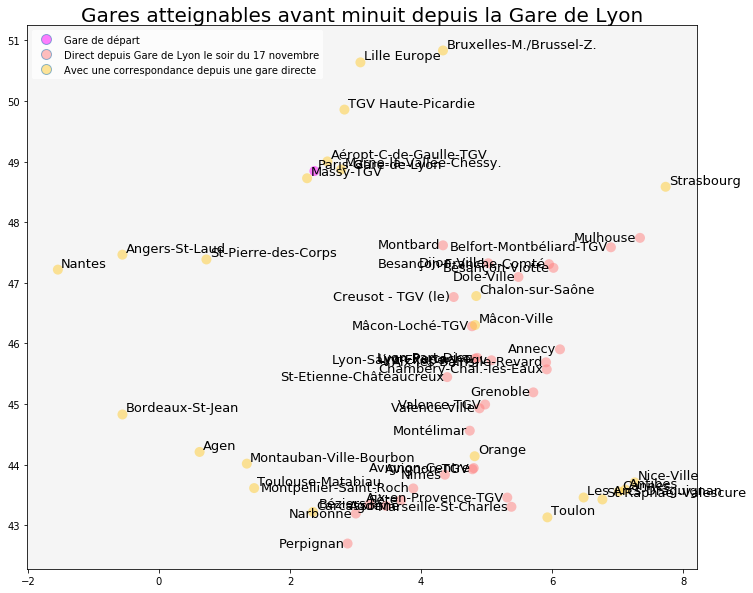

In [ ]:
### La carte 
###################################################################################################

import mpld3
%matplotlib inline

mpld3.enable_notebook()

def liste_unique(liste) : 
    unicite = [] 
    for x in liste : 
        if x in unicite :
            pass
        else :
            unicite.append(x)
    return unicite

lab_un = liste_unique(labels)
lat_un = liste_unique(lat)
lon_un = liste_unique(lon)

fig = plt.figure(figsize=(12,10))

for label, x, y in set(zip(labels, lon, lat)) :
    if dict_type_gares[label] == "direct" :  
        plt.annotate(label, xy = (x - 0.05, y - 0.05), horizontalalignment = 'right', size = 13)
    else :
        plt.annotate(label, xy = (x + 0.05, y + 0.05), horizontalalignment = 'left', size = 13)

colors = []     
for x in lab_un : 
    if dict_type_gares[x] == "depart" : 
        colors.append(liste_couleurs[0])
    if dict_type_gares[x] == "direct" :
        colors.append(liste_couleurs[1])
    if dict_type_gares[x] == "correspondance" : 
        colors.append(liste_couleurs[2])
                
        
plt.scatter(x = lon_un , y = lat_un, marker = "o", c = colors, s = 100, alpha = 0.5)

#### Legende

circ1 = Line2D([0], [0], linestyle="none", marker="o", alpha=0.5, markersize=10, markerfacecolor = liste_couleurs[0])
circ2 = Line2D([0], [0], linestyle="none", marker="o", alpha=0.5, markersize=10, markerfacecolor = liste_couleurs[1])
circ3 = Line2D([0], [0], linestyle="none", marker="o", alpha=0.5, markersize=10, markerfacecolor = liste_couleurs[2])

legende = plt.legend((circ1, circ2, circ3), ("Gare de départ", "Direct depuis Gare de Lyon le soir du 17 novembre", 
                                             "Avec une correspondance depuis une gare directe"), numpoints=1, loc="best")

legende.get_frame().set_facecolor('white')

plt.title("Gares atteignables avant minuit depuis la Gare de Lyon", size = 20)